 * Lipophilicty dataset from MoleculeNet:
 
 Experimental results of octanol/water distribution coefficient(logD at pH 7.4).

In [1]:
# importing necessary libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.feature_selection import VarianceThreshold


from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors

# Generate Morgan fingerprints
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

import lazypredict
from lazypredict.Supervised import LazyRegressor

from pycaret.regression import *

import mols2grid

tqdm.pandas() # Enable Pandas progress_apply
sns.set() # Make Pandas use Seaborn for plots

import shutup
shutup.please()

In [2]:
# Reading the dataset
df= pd.read_csv('Lipophilicity.csv')

df.tail()

,CMPD_CHEMBLID,exp,smiles
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3
4199,CHEMBL237889,2.70,CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N


In [3]:
df = df.drop('CMPD_CHEMBLID', axis= 1)

In [4]:
df = df.rename(columns= {'exp': 'Lipophilicity'})
df.head(2)

,Lipophilicity,smiles
0,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...


#### Generating canonical smiles.

In [5]:
def canonical_smiles(smile):
    molecule = Chem.MolFromSmiles(smile) 
    smiles   = Chem.MolToSmiles(molecule) 
    return smiles

In [6]:
df['Canonical_smiles'] = df['smiles'].apply(canonical_smiles)

df.tail()

,Lipophilicity,smiles,Canonical_smiles
4195,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,O=C(Nc1ccc(CCO)cc1)c1cc2cc(Cl)ccc2[nH]1
4196,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...
4197,2.10,COc1cccc2[nH]ncc12,COc1cccc2[nH]ncc12
4198,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,O=C(NCC1CCCCC1)c1c(Cl)ccc2ncccc12
4199,2.70,CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N,Cn1c(N)nc(CCc2ccc3ccccc3c2)cc1=O


In [7]:
df = df.drop('smiles', axis=1)

### Exploratory Data Analysis.

In [8]:
# Checking of empty entries in the dataset.
df.isna().sum()

Lipophilicity       0
Canonical_smiles    0
dtype: int64

In [9]:
df.dtypes

Lipophilicity       float64
Canonical_smiles     object
dtype: object

In [10]:
# Checking for duplicate smiles 
print( len(df['Canonical_smiles'].unique()) , len(df['Canonical_smiles']))

print()

print(len(df[df['Canonical_smiles'].duplicated()]))

4200 4200

0


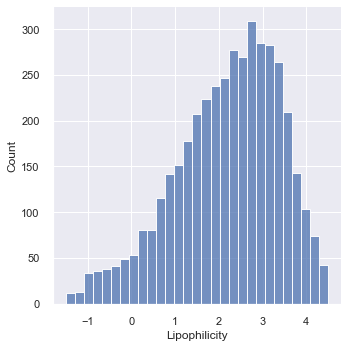

In [11]:
sns.displot(x= 'Lipophilicity', data= df);

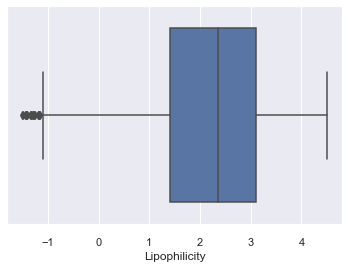

In [12]:
sns.boxplot(x= 'Lipophilicity', data= df);

In [13]:
# Dropping outliers.
outliers= df[df['Lipophilicity']< -1]
len(outliers)

36

In [14]:
df = df.drop(outliers.index)
df = df.reset_index(drop= True)

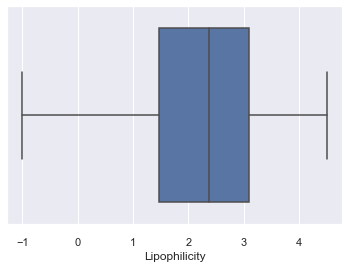

In [15]:
sns.boxplot(x= 'Lipophilicity', data= df);

In [16]:
df.Lipophilicity.describe()

count   4164.00
mean       2.22
std        1.17
min       -1.00
25%        1.46
50%        2.38
75%        3.10
max        4.50
Name: Lipophilicity, dtype: float64

In [17]:
# # Viewing some molecules.

PandasTools.AddMoleculeColumnToFrame(df,'Canonical_smiles', 'Structure')

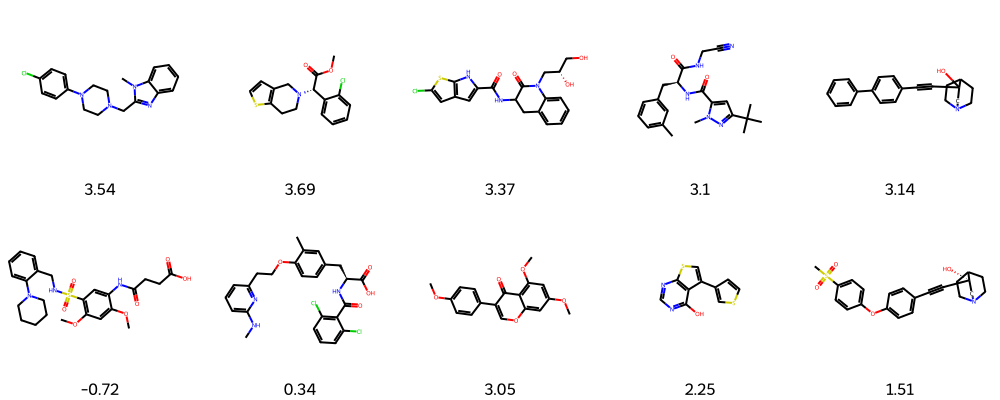

In [18]:
Draw.MolsToGridImage([x for x in df["Structure"]][:10], maxMols=100, 
                     legends=[str(x) for x in df.Lipophilicity], 
                     subImgSize=(200,200), molsPerRow=5)

#### Calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES. 

In [19]:
def calc_descriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, 
                                                               NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

In [20]:
df['desc'] = df.Canonical_smiles.apply(calc_descriptors)

In [21]:
df.head(2)

,Lipophilicity,Canonical_smiles,Structure,desc
0,3.54,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x000001C6A2C...,"[340.85800000000006, 3.5489000000000024, 3, 0, 4]"
1,3.69,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,<rdkit.Chem.rdchem.Mol object at 0x000001C6A2C...,"[321.829, 3.6739000000000024, 2, 0, 4]"


In [22]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
df[desc_cols] = df.desc.to_list()

df = df.drop("desc",axis=1)

df.head(2)


,Lipophilicity,Canonical_smiles,Structure,MW,LogP,NumAromatic,HBD,HBA
0,3.54,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x000001C6A2C...,340.86,3.55,3.00,0.00,4.00
1,3.69,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,<rdkit.Chem.rdchem.Mol object at 0x000001C6A2C...,321.83,3.67,2.00,0.00,4.00


#### Scatter plot of Lipophilicity versus LogP

Text(0, 0.5, 'LogP')

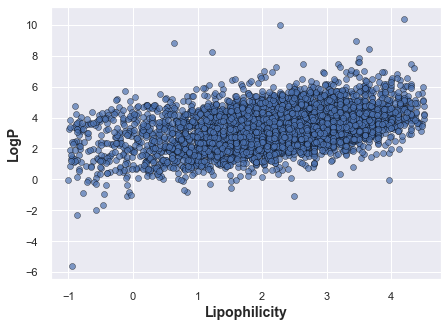

In [23]:
plt.figure(figsize=(7, 5))

sns.scatterplot(x='Lipophilicity', y='LogP', data=df,  
                edgecolor='black', alpha=0.7)

plt.xlabel('Lipophilicity', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')


#### Scatter plot of Lipophilicity versus MW

Text(0, 0.5, 'MW')

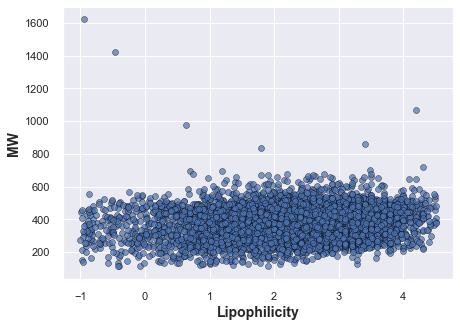

In [24]:
plt.figure(figsize=(7, 5))

sns.scatterplot(x='Lipophilicity', y='MW', data=df,  
                edgecolor='black', alpha=0.7)

plt.xlabel('Lipophilicity', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')


Text(0, 0.5, 'Lipophilicity')

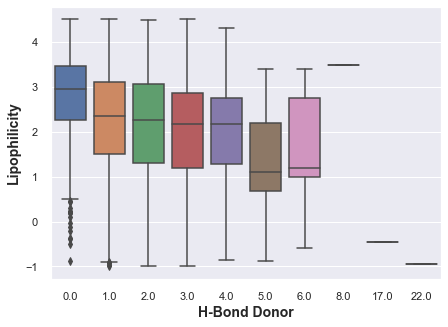

In [25]:
plt.figure(figsize=(7, 5))

sns.boxplot(x = 'HBD', y = 'Lipophilicity', data = df)

plt.xlabel('H-Bond Donor', fontsize=14, fontweight='bold')
plt.ylabel('Lipophilicity', fontsize=14, fontweight='bold')

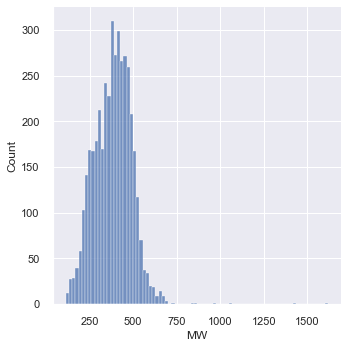

In [26]:
sns.displot(x= 'MW', data= df);

In [27]:
df = df.drop('LogP', axis= 1) 
df.shape

(4164, 7)

In [28]:
df.head(2)

,Lipophilicity,Canonical_smiles,Structure,MW,NumAromatic,HBD,HBA
0,3.54,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x000001C6A2C...,340.86,3.00,0.00,4.00
1,3.69,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,<rdkit.Chem.rdchem.Mol object at 0x000001C6A2C...,321.83,2.00,0.00,4.00


### Calculating RDKit molecular descriptors.

In [29]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 


In [30]:
rdkit_descriptors, desc_names = RDkit_descriptors(df['Canonical_smiles'])

In [31]:
rdkit_descriptors = pd.DataFrame(rdkit_descriptors, columns= desc_names)

In [32]:
rdkit_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.84,-4.08,8.84,0.01,0.73,340.86,319.69,340.15,124,0,...,0,0,0,0,0,0,0,0,0,0
1,13.32,-3.91,13.32,0.25,0.81,321.83,305.70,321.06,110,0,...,0,0,0,0,0,0,0,1,0,0
2,14.21,-4.27,14.21,0.19,0.51,419.89,401.75,419.07,146,0,...,0,0,0,0,0,0,0,1,0,0
3,14.17,-4.81,14.17,0.67,0.75,381.48,354.26,381.22,148,0,...,0,0,0,0,0,0,0,0,0,0
4,8.89,-4.00,8.89,0.48,0.82,303.40,282.24,303.16,116,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159,13.17,-3.42,13.17,0.19,0.69,314.77,299.65,314.08,112,0,...,0,0,0,0,0,0,0,0,0,0
4160,15.03,-5.95,15.03,1.52,0.33,554.70,518.42,554.24,208,0,...,0,0,1,0,0,0,0,0,0,0
4161,7.64,-2.87,7.64,0.22,0.67,148.17,140.10,148.06,56,0,...,0,0,0,0,0,0,0,0,0,0
4162,13.56,-4.42,13.56,0.71,0.92,302.80,283.65,302.12,110,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
rdkit_descriptors.to_csv('rdkit_descriptors.csv', index= False)

In [34]:
rdkit_descriptors = pd.read_csv('rdkit_descriptors.csv')
rdkit_descriptors.head(2)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.84,-4.08,8.84,0.01,0.73,340.86,319.69,340.15,124,0,...,0,0,0,0,0,0,0,0,0,0
1,13.32,-3.91,13.32,0.25,0.81,321.83,305.70,321.06,110,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(np.bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
   
    return descriptors_correlated_dropped  

In [36]:
descriptors_new = remove_correlated_features(rdkit_descriptors)
descriptors_new.shape

['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa2', 'Kappa3', 'LabuteASA', 'SMR_VSA1', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'HeavyAtomCount', 'NOCount', 'NumHDonors', 'NumSaturatedCarbocycles', 'NumSaturatedRings', 'MolMR', 'fr_COO2', 'fr_C_O_noCOO', 'fr_Nhpyrrole', 'fr_benzene', 'fr_ketone_Topliss', 'fr_nitro_arom', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_ester']


(4164, 163)

In [37]:
# Remove low variance features

selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))    
df_descriptors = selection.fit_transform(descriptors_new)

In [38]:
df_descriptors = pd.DataFrame(df_descriptors).reset_index(drop= True)
df_descriptors

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,8.84,-4.08,340.86,10.51,1.51,2.12,-2.04,1380883697.25,4.57,9.47,...,0.00,1.00,1.00,1.00,0.00,1.00,0.00,2.00,0.00,0.00
1,13.32,-3.91,321.83,11.25,2.01,2.57,-1.36,31620848.89,4.82,4.74,...,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00
2,14.21,-4.27,419.89,11.76,2.48,2.10,-2.39,3516593713.80,7.14,25.40,...,2.00,1.00,0.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00
3,14.17,-4.81,381.48,10.01,0.00,3.34,-3.14,35930662063.06,5.07,10.62,...,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,8.89,-4.00,303.40,10.09,1.07,2.09,-2.08,887229553.30,4.11,5.11,...,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,3.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159,13.17,-3.42,314.77,11.28,2.60,2.28,-2.30,54274487.93,5.11,15.40,...,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
4160,15.03,-5.95,554.70,10.25,0.67,2.27,-3.10,263643858358187.44,7.79,9.80,...,1.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,0.00
4161,7.64,-2.87,148.17,11.10,2.21,2.89,-1.51,12468.16,2.00,4.74,...,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00
4162,13.56,-4.42,302.80,10.11,1.45,2.40,-1.61,100918958.20,4.02,5.31,...,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00


In [39]:
target = pd.Series(df['Lipophilicity'])


df_final = pd.concat([df_descriptors, target], axis= 1)

df_final

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,Lipophilicity
0,8.84,-4.08,340.86,10.51,1.51,2.12,-2.04,1380883697.25,4.57,9.47,...,1.00,1.00,1.00,0.00,1.00,0.00,2.00,0.00,0.00,3.54
1,13.32,-3.91,321.83,11.25,2.01,2.57,-1.36,31620848.89,4.82,4.74,...,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,3.69
2,14.21,-4.27,419.89,11.76,2.48,2.10,-2.39,3516593713.80,7.14,25.40,...,1.00,0.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,3.37
3,14.17,-4.81,381.48,10.01,0.00,3.34,-3.14,35930662063.06,5.07,10.62,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.10
4,8.89,-4.00,303.40,10.09,1.07,2.09,-2.08,887229553.30,4.11,5.11,...,0.00,0.00,3.00,0.00,0.00,0.00,0.00,3.00,0.00,3.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159,13.17,-3.42,314.77,11.28,2.60,2.28,-2.30,54274487.93,5.11,15.40,...,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,3.85
4160,15.03,-5.95,554.70,10.25,0.67,2.27,-3.10,263643858358187.44,7.79,9.80,...,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,0.00,3.21
4161,7.64,-2.87,148.17,11.10,2.21,2.89,-1.51,12468.16,2.00,4.74,...,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,2.10
4162,13.56,-4.42,302.80,10.11,1.45,2.40,-1.61,100918958.20,4.02,5.31,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2.65


In [40]:
df_final = df_final.dropna().reset_index(drop= True)

In [41]:
# df_final.isnull().sum().to_list()

### Preparing the data for ML models.

In [42]:
X = df_final.drop('Lipophilicity', axis= 1)
y = df_final['Lipophilicity']

In [43]:
len(X) , len(y)

(4163, 4163)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((3330, 94), (3330,), (833, 94), (833,))

In [46]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
2267,14.13,-4.41,325.38,10.67,1.00,2.43,-2.49,552140339.37,4.78,4.90,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
567,9.58,-4.30,404.47,10.96,1.79,2.21,-3.67,60883367601.46,6.17,25.37,...,0.00,4.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
1633,8.90,-3.48,339.39,10.80,0.75,2.59,-2.95,1172665703.75,4.81,18.95,...,0.00,0.00,0.00,1.00,4.00,0.00,4.00,0.00,0.00,1.00
1775,14.84,-4.22,526.00,11.64,2.62,2.04,-4.42,4476404323984.18,9.10,4.57,...,0.00,0.00,0.00,2.00,0.00,1.00,0.00,0.00,0.00,1.00
1946,13.76,-4.51,462.60,0.00,0.00,2.03,-3.46,14001239599682.99,5.84,24.58,...,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,13.54,-6.14,483.59,10.71,1.23,2.27,-3.21,1953867795345.67,6.93,24.96,...,0.00,5.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
4104,13.23,-4.60,212.29,-0.00,-0.00,4.19,-1.06,3442300.08,2.03,10.62,...,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1657,13.33,-3.93,352.39,11.11,2.09,2.33,-3.28,1545093089.20,5.36,19.52,...,1.00,1.00,1.00,1.00,3.00,0.00,2.00,2.00,0.00,1.00
2374,13.54,-6.70,394.41,11.15,0.79,2.89,-1.81,895835194.01,6.10,14.39,...,1.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00


In [47]:
pd.Series(y_train)

2267   3.40
567    1.20
1633   2.81
1775   4.27
1946   3.31
       ... 
1470   2.90
4104   0.58
1657   3.90
2374   1.64
3946   2.46
Name: Lipophilicity, Length: 3330, dtype: float64

In [48]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### PyCaret module for different ML algorithms.

In [49]:
# pip install -U --pre pycaret

In [50]:
model = setup(data = df_final, target = 'Lipophilicity', train_size=0.8)

,Description,Value
0,Session id,8994
1,Target,Lipophilicity
2,Target type,Regression
3,Original data shape,"(4163, 95)"
4,Transformed data shape,"(4163, 95)"
5,Transformed train set shape,"(3330, 95)"
6,Transformed test set shape,"(833, 95)"
7,Numeric features,94
8,Preprocess,True
9,Imputation type,simple


In [51]:
result = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5188,0.4754,0.6883,0.6461,0.2414,0.8060,0.2330
omp,Orthogonal Matching Pursuit,0.7767,0.9453,0.9712,0.2998,0.3252,1.3559,0.0260
llar,Lasso Least Angle Regression,0.9488,1.3540,1.1626,-0.0018,0.3884,1.8501,0.0260
dummy,Dummy Regressor,0.9488,1.3540,1.1626,-0.0018,0.3884,1.8501,0.0250
knn,K Neighbors Regressor,0.9812,1.4987,1.2231,-0.1107,0.4074,1.6949,0.0420
lasso,Lasso Regression,77.7384,19681082.3914,1403.8385,-12969734.1066,0.3923,83.4348,0.1500
en,Elastic Net,498.6666,825324825.9624,9085.6525,-543884938.0064,0.3893,531.1747,0.1480
lr,Linear Regression,1629.7023,8833961090.4058,29723.0196,-5821536243.9274,0.4379,1734.5674,1.1000
br,Bayesian Ridge,1632.0651,8859610718.5878,29766.1376,-5838439220.8139,0.4379,1737.0811,0.0380
ridge,Ridge Regression,2005.4097,13383319909.9605,36583.9734,-8819540988.0326,0.3421,2133.7572,0.1080


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [52]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5193,0.4459,0.6678,0.6802,0.2459,0.7287
1,0.4883,0.4298,0.6556,0.6835,0.2339,0.7335
2,0.5007,0.4036,0.6353,0.6993,0.2198,0.5198
3,0.5355,0.5236,0.7236,0.6210,0.2706,1.6509
4,0.5346,0.5224,0.7228,0.5647,0.2407,0.4629
5,0.5634,0.5897,0.7679,0.6114,0.2705,1.0467
6,0.5150,0.4603,0.6784,0.6715,0.2378,0.8602
7,0.4976,0.4522,0.6724,0.5988,0.2383,0.4479
8,0.5001,0.4095,0.6400,0.7224,0.2270,1.0801


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [53]:
tuned_lightgbm = tune_model(lightgbm, n_iter = 50, optimize = 'R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5099,0.4557,0.6751,0.6732,0.2391,0.6944
1,0.4960,0.4497,0.6706,0.6689,0.2348,0.7883
2,0.5080,0.4120,0.6419,0.6931,0.2203,0.5308
3,0.5487,0.5582,0.7472,0.5959,0.2706,1.6733
4,0.5389,0.5252,0.7247,0.5624,0.2444,0.4556
5,0.5526,0.5705,0.7553,0.6241,0.2563,0.8367
6,0.5086,0.4493,0.6703,0.6793,0.2363,0.8533
7,0.5064,0.4777,0.6912,0.5762,0.2493,0.4641
8,0.5077,0.4285,0.6546,0.7095,0.2330,1.0555


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


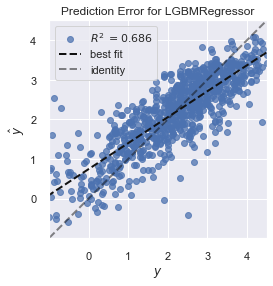

In [54]:
plot_model(tuned_lightgbm, 'error')

In [55]:
plot_model(tuned_lightgbm, 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


#### Prediction on test data.

In [56]:
prediction_holdout = predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.4983,0.4320,0.6573,0.6864,0.2173,0.5172


In [57]:
# True and predicted labels of test samples.
prediction_holdout.iloc[:, -2:]

,Lipophilicity,prediction_label
1754,3.30,2.83
732,2.90,1.58
1132,-0.73,0.18
3533,3.50,2.50
540,1.70,2.65
...,...,...
3873,3.10,3.43
3498,3.26,3.23
714,0.67,1.74
448,2.65,1.75


#### Plotting true versus predicted labels.

In [58]:
true , predicted = prediction_holdout.iloc[:, -2], prediction_holdout.iloc[:, -1]

<AxesSubplot:xlabel='Lipophilicity', ylabel='prediction_label'>

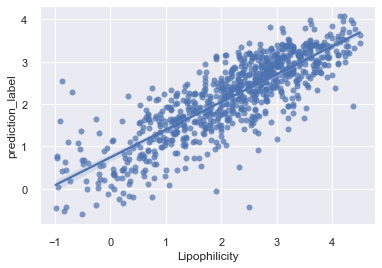

In [59]:
sns.regplot(true, predicted, scatter_kws={'alpha':0.7})


In [64]:
model_tuned = LGBMRegressor()

model_tuned.fit(X_train, y_train)

y_preds = model_tuned.predict(X_test)

r2_score(y_test , y_preds)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10783
[LightGBM] [Info] Number of data points in the train set: 3330, number of used features: 92
[LightGBM] [Info] Start training from score 2.222553


0.6720086777131822

### Stacking of ML models.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10783
[LightGBM] [Info] Number of data points in the train set: 3330, number of used features: 92
[LightGBM] [Info] Start training from score 2.222553
{'Linear Model': -0.0009106414132231677, 'Random Forest Regressor': 0.6515261658965898, 'ExtraTreesRegressor': 0.6723778379109762, 'AdaBoostRegressor': 0.3439977328129039, 'GradientBoostingRegressor': 0.5605674765918138, 'HistGradientBoostingRegressor': 0.6740521515799007, 'BaggingRegressor': 0.5990226052609211, 'LGBMRegressor': 0.6720086777131822, 'TransformedTargetRegressor': 0.4360357713298605, 'Decision Tree Regressor': 0.26405091131785585, 'Support Vector Regressor': 0.6559607826079555, 'KNN Regressor': 0.4924777665576173, 'XGBRegressor': 0.6476887126410176, 'MLPRegressor': 0.5766320135705655}


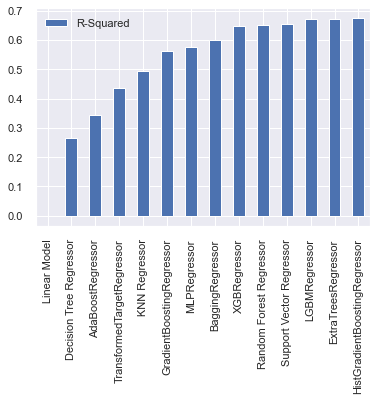

In [63]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PoissonRegressor


from sklearn.ensemble     import RandomForestRegressor
from sklearn.ensemble     import ExtraTreesRegressor
from sklearn.ensemble     import AdaBoostRegressor
from sklearn.ensemble     import GradientBoostingRegressor
from sklearn.ensemble     import HistGradientBoostingRegressor
from sklearn.ensemble     import BaggingRegressor

from lightgbm             import LGBMRegressor
from sklearn.compose      import TransformedTargetRegressor

from sklearn.tree         import DecisionTreeRegressor
from sklearn.svm          import SVR
from sklearn.neighbors    import KNeighborsRegressor
from xgboost              import XGBRegressor
from sklearn.neural_network import MLPRegressor



models= {"Linear Model": ElasticNet(),
         #"SGDRegressor": SGDRegressor(),
         #"PoissonRegressor": PoissonRegressor(),
         "Random Forest Regressor": RandomForestRegressor(),
         "ExtraTreesRegressor": ExtraTreesRegressor(),
         "AdaBoostRegressor": AdaBoostRegressor(),
         "GradientBoostingRegressor": GradientBoostingRegressor(),
         "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
         "BaggingRegressor": BaggingRegressor(),
         "LGBMRegressor": LGBMRegressor(),
         "TransformedTargetRegressor": TransformedTargetRegressor(),
         "Decision Tree Regressor": DecisionTreeRegressor(),
         "Support Vector Regressor": SVR(),
         "KNN Regressor": KNeighborsRegressor(),
         "XGBRegressor": XGBRegressor(),
         "MLPRegressor": MLPRegressor() }



def classify (models , X_train , X_test , y_train , y_test):
    
    model_scores= {}
    
    for name , model in models.items():

        model.fit(X_train , y_train)
    
        model_scores[name]= model.score(X_test , y_test)
        
    return model_scores


model_scores= classify(models=models,
                      X_train= X_train,
                      X_test= X_test,
                      y_train= y_train,
                      y_test= y_test)

print(model_scores)



models_compare= pd.DataFrame(model_scores , index=['R-Squared'])

models_compare.T.sort_values(by= ['R-Squared']).plot.bar();

#### Using the best four models for stacking.

In [65]:
# Define estimators
from sklearn.ensemble import StackingRegressor

estimator_list = [
    ('ExtraTreesRegressor',ExtraTreesRegressor()),
    ('HistGradientBoostingRegressor',HistGradientBoostingRegressor()),
    ('SVR',SVR()) ]

# Build stack model
stack_model = StackingRegressor(
    estimators=estimator_list, final_estimator=LGBMRegressor() )

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

# Training set model performance
stack_model_train_r2 = r2_score(y_train, y_train_pred) 
stack_model_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred)) 

# Test set model performance
stack_model_test_r2 = r2_score(y_test, y_test_pred) 
stack_model_test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred)) 

print('Model performance for Training set')
print(f'R2 ={stack_model_train_r2:.2f}')
print(f'RMSE ={stack_model_train_RMSE:.2f}')
print('----------------------------------')
print('Model performance for Test set')
print(f'R2 ={stack_model_test_r2:.2f}')
print(f'RMSE ={stack_model_test_RMSE:.2f}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 3330, number of used features: 3
[LightGBM] [Info] Start training from score 2.222553
Model performance for Training set
R2 =0.93
RMSE =0.30
----------------------------------
Model performance for Test set
R2 =0.69
RMSE =0.65
